## Setup

### Libraries and Helper Functions


In [1]:
#@title Imports

import numpy as np
import pandas as pd
import sklearn as sk
import os
import nltk
from nltk.data import find
import matplotlib.pyplot as plt
import re

from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/muthumayan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/muthumayan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
#@title Utility print function

def print_version(library_name):
    try:
        lib = __import__(library_name)
        version = getattr(lib, '__version__', 'Version number not found')
        print(f"{library_name} version: {version}")
    except ImportError:
        print(f"{library_name} not installed.")
    except Exception as e:
        print(f"An error occurred: {e}")

#confirm versions
print_version('numpy')
print_version('pandas')
print_version('sklearn')

numpy version: 1.24.4
pandas version: 1.5.3
sklearn version: 1.2.1


In [3]:
#@title Utility Plot Function

# 4-window plot. Small modification from matplotlib examples.

def make_plot(axs,
              model_history1,
              model_history2,
              model_1_name='model 1',
              model_2_name='model 2',
              ):
    box = dict(facecolor='yellow', pad=5, alpha=0.2)

    for i, metric in enumerate(['loss', 'accuracy']):
        # small adjustment to account for the 2 accuracy measures in the Weighted Averging Model with Attention
        if 'classification_%s' % metric in model_history2.history:
            metric2 = 'classification_%s' % metric
        else:
            metric2 = metric

        y_lim_lower1 = np.min(model_history1.history[metric])
        y_lim_lower2 = np.min(model_history2.history[metric2])
        y_lim_lower = min(y_lim_lower1, y_lim_lower2) * 0.9

        y_lim_upper1 = np.max(model_history1.history[metric])
        y_lim_upper2 = np.max(model_history2.history[metric2])
        y_lim_upper = max(y_lim_upper1, y_lim_upper2) * 1.1

        for j, model_history in enumerate([model_history1, model_history2]):
            model_name = [model_1_name, model_2_name][j]
            model_metric = [metric, metric2][j]
            ax1 = axs[i, j]
            ax1.plot(model_history.history[model_metric])
            ax1.plot(model_history.history['val_%s' % model_metric])
            ax1.set_title('%s - %s' % (metric, model_name))
            ax1.set_ylabel(metric, bbox=box)
            ax1.set_ylim(y_lim_lower, y_lim_upper)

In [4]:
#@title Read Reddit dataset into a dataframe
rdt_trainfile = '~/mids-w266-project/Reddit/both_train.csv'
rdt_tesstfile = '~/mids-w266-project/Reddit/both_test.csv'
rdt_train = pd.read_csv(rdt_trainfile)
rdt_test = pd.read_csv(rdt_tesstfile)

# Shuffle all rows
rdt_train = rdt_train.sample(frac=1).reset_index(drop=True)
rdt_test = rdt_test.sample(frac=1).reset_index(drop=True)

train_labels = rdt_train.class_id
test_labels = rdt_test.class_id

train_examples = rdt_train.post
test_examples = rdt_test.post

In [5]:
mh_cls_names = list(rdt_train.class_name.unique())
mh_cls_names

['anxiety', 'none', 'bipolar', 'ptsd', 'depression', 'adhd']

In [6]:
mh_cls_id = list(rdt_train.class_id.unique())
mh_cls_id

[1, 5, 2, 4, 3, 0]

In [7]:
mh_dict_id_to_name = {}
mh_dict_name_to_id = {}
for idx, value in enumerate(mh_cls_id):
    mh_dict_id_to_name[value] = mh_cls_names[idx]
for idx, value in enumerate(mh_cls_names):
    mh_dict_name_to_id[value] = mh_cls_id[idx]
    
mh_dict_id_to_name 
mh_dict_name_to_id

{'anxiety': 1, 'none': 5, 'bipolar': 2, 'ptsd': 4, 'depression': 3, 'adhd': 0}

In [8]:
freqcount = np.zeros((6,6), dtype=int)

for name in mh_cls_names:
    mh_cls_id = mh_dict_name_to_id[name]
    # For each class, check to see if the name exists in the text. If it does, then
    # increment the relevant matrix
    for i in range(len(rdt_train)):  
        # Tokenize the text
        text = rdt_train.post[i]
        tokens = word_tokenize(text.lower())  # Convert to lowercase to count words in a case-insensitive manner
        # Get class name of text
        cls = rdt_train.class_name[i]
        clsid = rdt_train.class_id[i]
        if name in tokens:
            freqcount[mh_cls_id][clsid] += 1


In [9]:
freqcount

array([[1104,   11,   38,    5,    8,    2],
       [ 203, 1320,  253,  187,  285,    9],
       [  22,   15,  763,   12,   29,    1],
       [ 157,  181,  427,  641,  168,   16],
       [   4,   23,   26,    9,  907,    0],
       [  40,   35,   54,   48,   44,   26]])

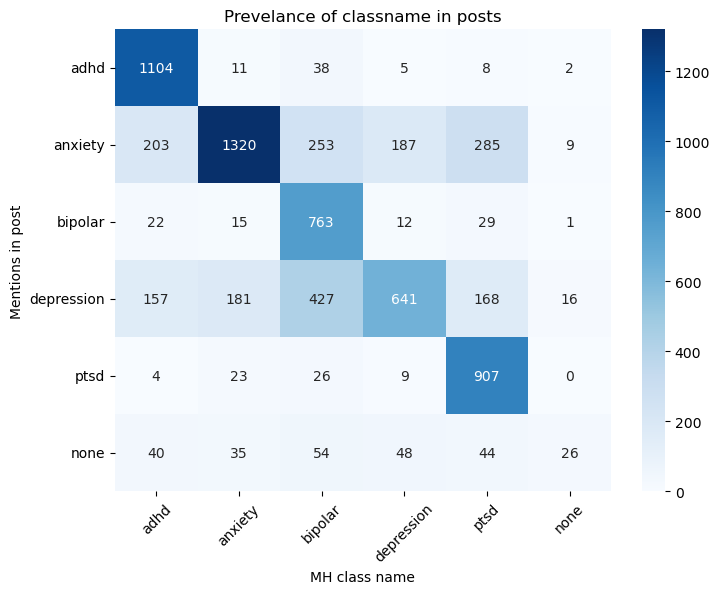

In [12]:

# Plot the confusion matrix
mh_class_names = [mh_dict_id_to_name[i] for i in range(len(mh_cls_names))]
text_mentions = [mh_dict_id_to_name[i] for i in range(len(mh_cls_names))]

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(freqcount, annot=True, fmt='d', cmap='Blues')

# Add string labels to the axes
plt.xticks(ticks=np.arange(len(mh_class_names)) + 0.5, labels=mh_class_names, rotation=45)
plt.yticks(ticks=np.arange(len(text_mentions)) + 0.5, labels=text_mentions, rotation=0)

# Add labels, title, and color bar
plt.xlabel('MH class name')
plt.ylabel('Mentions in post')
plt.title('Prevelance of classname in posts')
plt.show()

In [13]:
#@title Inspect data and label characteristics

print(f'Training set labels shape: {train_labels.shape}')
print(f'Test set labels shape: {test_labels.shape}')

print(f'Training set examples shape: {train_examples.shape}')
print(f'Test set examples shape: {test_examples.shape}')

print(f'Distribution of the length of all title')
print(rdt_train["title"].str.len().describe())

print('Distribution of the length of all posts')
print(rdt_train["post"].str.len().describe())

print(f'Labels min : {rdt_train.class_id.min()} max : {rdt_train.class_id.max()}')


Training set labels shape: (13727,)
Test set labels shape: (1488,)
Training set examples shape: (13727,)
Test set examples shape: (1488,)
Distribution of the length of all title
count    13727.000000
mean        67.111751
std         48.713468
min          2.000000
25%         34.000000
50%         54.000000
75%         85.000000
max        306.000000
Name: title, dtype: float64
Distribution of the length of all posts
count    13727.000000
mean      1065.297734
std       1373.414370
min        123.000000
25%        362.000000
50%        658.000000
75%       1236.500000
max      38168.000000
Name: post, dtype: float64
Labels min : 0 max : 5


In [16]:
#@title Distribution of labels in training and test sets
for i in range(np.max(train_labels)):
  pos_indices = np.where(train_labels == i)
  pct_positive = len(pos_indices[0])/len(train_labels)
  print(f'Labels {i} in training set: {len(pos_indices[0])}/{len(train_labels)} ({pct_positive})')

for i in range(np.max(test_labels)):
  pos_indices = np.where(test_labels == i)
  pct_positive = len(pos_indices[0])/len(test_labels)
  print(f'Labels {i} in test set: {len(pos_indices[0])}/{len(train_labels)} ({pct_positive})')


Labels 0 in training set: 2465/13727 (0.17957310410140598)
Labels 1 in training set: 2422/13727 (0.17644059153493116)
Labels 2 in training set: 2407/13727 (0.17534785459313762)
Labels 3 in training set: 2450/13727 (0.17848036715961244)
Labels 4 in training set: 2001/13727 (0.14577110803525897)
Labels 0 in test set: 248/13727 (0.16666666666666666)
Labels 1 in test set: 248/13727 (0.16666666666666666)
Labels 2 in test set: 248/13727 (0.16666666666666666)
Labels 3 in test set: 248/13727 (0.16666666666666666)
Labels 4 in test set: 248/13727 (0.16666666666666666)
